# Convolutional Autoencoder solution


In [ ]:
pip install git+https://github.com/albumentations-team/albumentations.git


In [1]:
import os
os.chdir("/teamspace/studios/this_studio/dcase2020_task2_variants")

In [2]:
os.chdir("/teamspace/studios/this_studio/dcase2020_task2_variants/")

In [4]:
!python image_preprocess_level1.py

Machine types: ['slider']
=== DCASE 2020 Challenge Task 2 Data Preprocessing LEVEL 1 ===
dc2020t2l1-slider-train.npy: making 2370 log mel spectrogram data as shape (2370, 64, 313)
/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider/train/normal_id_00_00000000.wav
/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider/train/normal_id_00_00000001.wav
/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider/train/normal_id_00_00000002.wav
/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider/train/normal_id_00_00000003.wav
/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider/train/normal_id_00_00000004.wav
/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider/train/normal_id_00_00000005.wav
/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider/train/normal_id_00_00000006.wav
/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider/train/normal_id_00_00000007.wav
/teamspace/s

In [3]:
# public modules
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)
from argparse import Namespace

# private modules
sys.path.append('..')
import common as com

from image_common import *
from model import CNNAutoEncoder
os.chdir("/teamspace/studios/this_studio/dcase2020_task2_variants/3cnn_ae_pytorch")
# loading parameters -> hparams (argparse compatible)
params = EasyDict(com.yaml_load('config.yaml'))

# create working directory
ensure_folder(params.model_directory)

# test targets
if 'target' in params:
    types = params.target
else:
    types = [d.name for d in Path(params.dev_directory).glob('*') if d.is_dir()]

# dataset
data_files = sorted(Path(params.dev_directory).glob('dc2020t2l1*.npy'))
data = {t:[f for f in data_files if t in str(f)] for t in types}

# fix random seeds
deterministic_everything(2020, pytorch=True)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Testing dataset class *if using albumentations*

**NOTE: We are not using augmentation in this example**

In [4]:
data

{'slider': [PosixPath('/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/dc2020t2l1-slider-test.npy'),
  PosixPath('/teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/dc2020t2l1-slider-train.npy')]}

In [5]:
types

['slider']

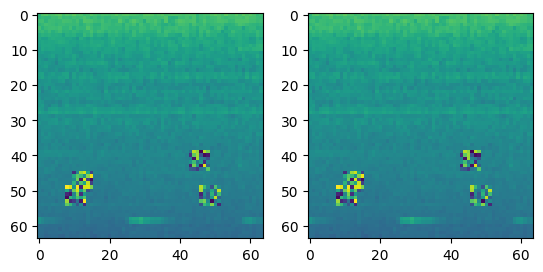

In [12]:
if True:  # test dataset
    import cv2
    import numpy as np
    from albumentations import (
        HorizontalFlip, ShiftScaleRotate, CLAHE, RandomRotate90, RandomCrop,
        Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
        GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, Flip, OneOf, Compose,
        ISONoise, CoarseDropout
    )
    import matplotlib.pyplot as plt

    class MyTfm():
        def __init__(self):
            self.album_tfm = Compose([
                CoarseDropout(max_holes=4, max_height=6, max_width=6, fill_value='random', p=0.6),
                ShiftScaleRotate(shift_limit=0.3, scale_limit=0.1, rotate_limit=0, p=.5),
            ], p=1)

        def __call__(self, x):
            # Ensure the image is in the correct format
            if not isinstance(x, np.ndarray):
                x = np.array(x)
            
            # Handle different data types appropriately
            if x.dtype == np.float32 or x.dtype == np.float64:
                if x.max() <= 1.0:
                    x = (x * 255).astype(np.uint8)
                else:
                    x = x.astype(np.uint8)
            elif x.dtype == np.uint16:
                x = (x / 256).astype(np.uint8)
            elif x.dtype != np.uint8:
                x = x.astype(np.uint8)

            data = {"image": x}
            augmented = self.album_tfm(**data)
            x = augmented["image"]
            return x

    # Assuming `data` and `types` are defined elsewhere in the code
    trn_ds = Task2ImageDataset(data[types[0]][1], augment_tfm=MyTfm(), aug_y=True, random=True)
    train_index = trn_ds.get_index_by_pct()
    trn_ds.train_split(train_index)
    fig, ax = plt.subplots(1, 2)
    one = trn_ds[0]
    ax[0].imshow(one[0])
    ax[1].imshow(one[1])
    plt.show()


In [13]:
class Task2ImageLightning(Task2Lightning):
    """Task2 PyTorch Lightning class, for training only."""

    def __init__(self, device, model, params, preprocessed_file, normalize=True):
        super().__init__(device, model, params, files=None, normalize=normalize)
        self.device_mine = device
        self.params = params
        self.normalize = normalize
        self.model = model
        self.mseloss = torch.nn.MSELoss()

        to_tensor = ToTensor1ch(device=self.device_mine, image=True)
        self.trn_ds = Task2ImageDataset(preprocessed_file, transform=to_tensor,
                                      normalize=normalize,augment_tfm=MyTfm(), aug_y=True)
        self.val_ds = Task2ImageDataset(preprocessed_file, transform=to_tensor,
                                      normalize=normalize, random=False,augment_tfm=MyTfm(), aug_y=True)
        train_index = self.trn_ds.get_index_by_pct()
        self.trn_ds.train_split(train_index)
        self.val_ds.val_split(train_index)

    def _get_dl(self, for_what):
        ds = self.trn_ds if for_what == 'train' else self.val_ds
        return torch.utils.data.DataLoader(ds, batch_size=self.params.fit.batch_size,
                          shuffle=(self.params.fit.shuffle if for_what == 'train' else False))

In [14]:
    model = CNNAutoEncoder().to(device)
    task2 = Task2ImageLightning(device, model, params, preprocessed_file=data['slider'][1])

In [12]:
# train models

for target in types:
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')

    model = CNNAutoEncoder().to(device)
    task2 = Task2ImageLightning(device, model, params, preprocessed_file=data[target][1])
    if target == 'slider': summary(device, model, input_size=task2.train_dataloader().dataset[0][0].shape)
    trainer = pl.Trainer(max_epochs=params.fit.epochs, devices=1, accelerator="gpu")
    trainer.fit(task2)

    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')

==== Start training [slider] with 1 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 1, 67, 67]               0
            Conv2d-2           [-1, 32, 32, 32]             832
       BatchNorm2d-3           [-1, 32, 32, 32]              64
              ReLU-4           [-1, 32, 32, 32]               0
         ZeroPad2d-5           [-1, 32, 35, 35]               0
            Conv2d-6           [-1, 64, 16, 16]          51,264
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
           Dropout-9           [-1, 64, 16, 16]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
      BatchNorm2d-11            [-1, 128, 8, 8]             256
             ReLU-12            [-1, 128, 8, 8]               0
          Dropout-13            [-1, 128, 8, 8]       

2024-05-25 17:32:46.274463: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 17:32:47.808626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 17:32:51.116721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

saved /teamspace/studios/this_studio/Logs_AML/CVAE2/model_slider.pth.



## Visualizing reconstruction results

In [15]:
load_weights(task2.model, '/teamspace/studios/this_studio/Logs_AML/CVAE2/model_slider.pth')
target = 'slider'

In [16]:
task2.model.to("cuda")

CNNAutoEncoder(
  (conv1): Sequential(
    (0): ZeroPad2d((1, 2, 1, 2))
    (1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): ZeroPad2d((1, 2, 1, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
 

In [17]:
def show_some_predictions(dl, model, start_index, n_samples, image=False):
    shape = (-1, 64, 64) if image else (-1, 640)
    x, y = next(iter(dl))
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        yhat = model(x)
    x = x.cpu().numpy().reshape(shape)
    yhat = yhat.cpu().numpy().reshape(shape)
    print(x.shape, yhat.shape)
    for sample_idx in range(start_index, start_index + n_samples):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        if image:
            axs[0].imshow(x[sample_idx])
            axs[1].imshow(yhat[sample_idx])
        else:
            axs[0].plot(x[sample_idx])
            axs[1].plot(yhat[sample_idx])

(1024, 64, 64) (1024, 64, 64)


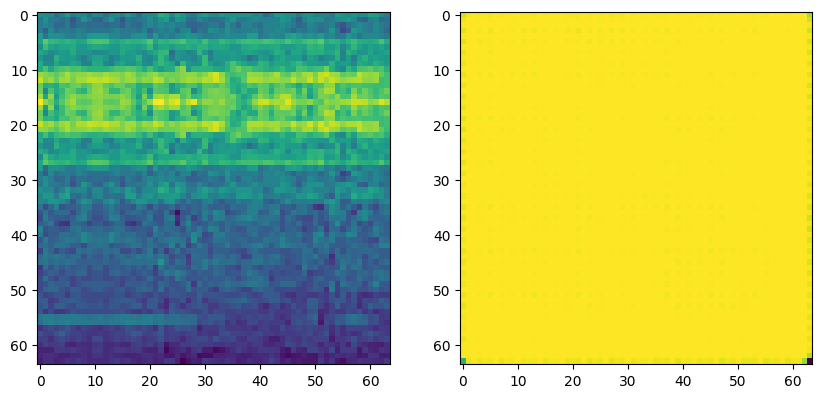

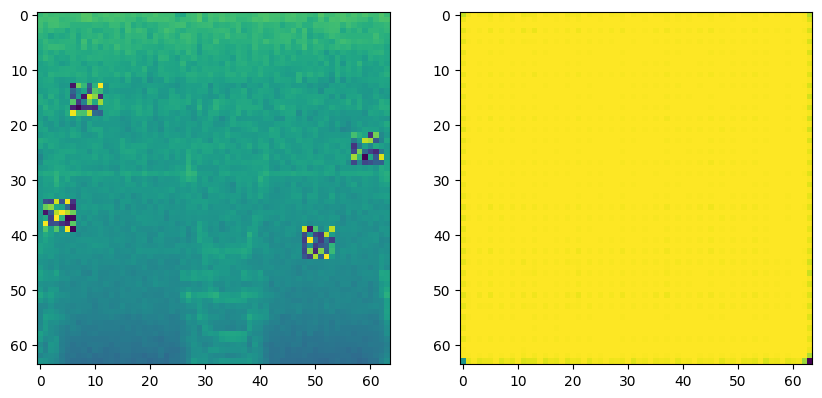

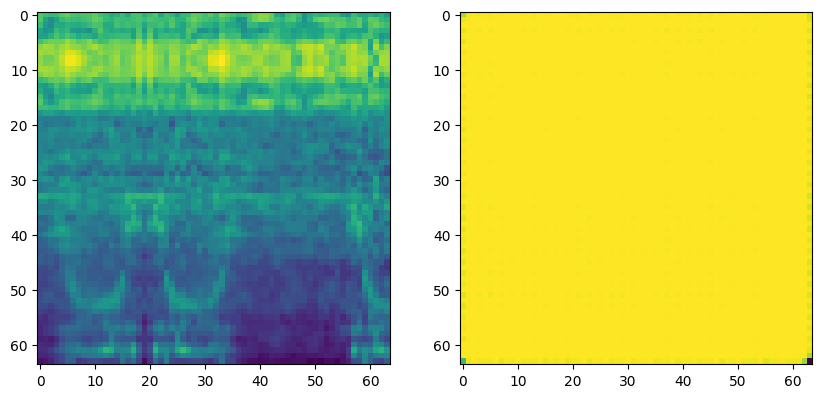

In [18]:
show_some_predictions(task2.train_dataloader(), task2.model, 0, 3, image=True)

(1024, 64, 64) (1024, 64, 64)


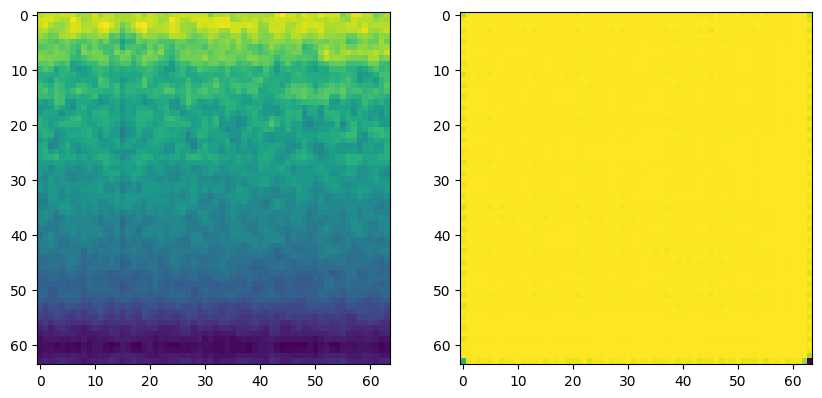

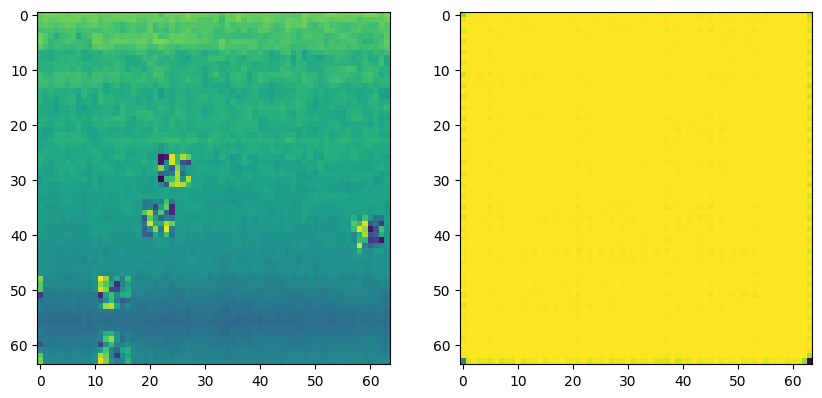

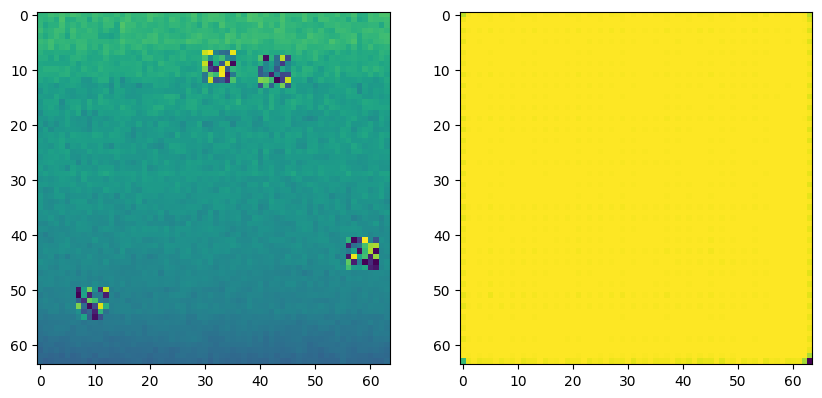

In [19]:
show_some_predictions(task2.val_dataloader(), task2.model, 0, 3, image=True)

## Test example with visualizations

2024-05-25 18:33:29,040 - INFO - load_directory <- development
2024-05-25 18:33:29,046 - INFO - loading model: /teamspace/studios/this_studio/Logs_AML/CVAE2/model_slider.pth



[1/1] /teamspace/studios/this_studio/SoundDataset/dev_data/dev_data/slider
============== MODEL LOAD ==============
model_file: /teamspace/studios/this_studio/Logs_AML/CVAE2/model_slider.pth


2024-05-25 18:33:29,690 - INFO - target_dir : slider_id_00
2024-05-25 18:33:29,758 - INFO - test_file  num : 456


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
       BatchNorm2d-3           [-1, 32, 64, 64]              64
              ReLU-4           [-1, 32, 64, 64]               0
         ZeroPad2d-5           [-1, 32, 67, 67]               0
            Conv2d-6           [-1, 64, 32, 32]          51,264
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
           Dropout-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14            [-1, 25

  0%|          | 0/456 [00:00<?, ?it/s]

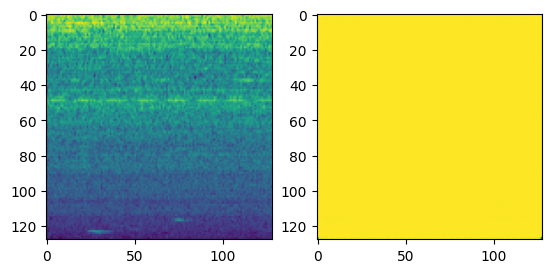

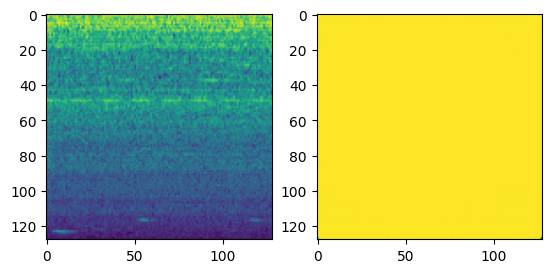

100%|██████████| 456/456 [01:06<00:00,  6.83it/s]
2024-05-25 18:34:36,628 - INFO - AUC : 0.9307303370786516
2024-05-25 18:34:36,638 - INFO - pAUC : 0.7871082199881727
2024-05-25 18:34:36,642 - INFO - target_dir : slider_id_02
2024-05-25 18:34:36,707 - INFO - test_file  num : 367



============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


  0%|          | 0/367 [00:00<?, ?it/s]

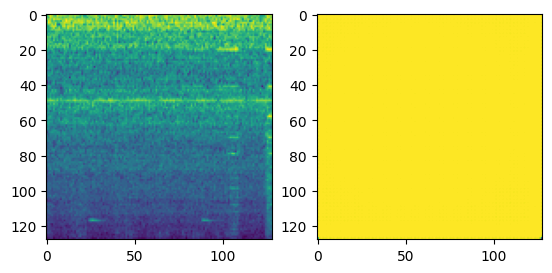

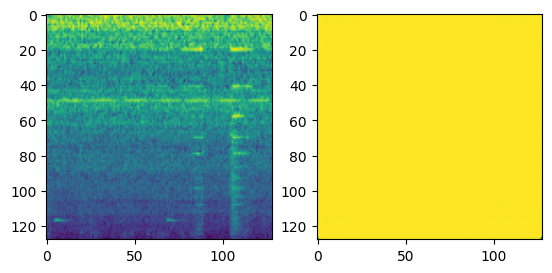

100%|██████████| 367/367 [00:49<00:00,  7.43it/s]
2024-05-25 18:35:26,126 - INFO - AUC : 0.752434456928839
2024-05-25 18:35:26,128 - INFO - pAUC : 0.57618766016164
2024-05-25 18:35:26,130 - INFO - target_dir : slider_id_04
2024-05-25 18:35:26,200 - INFO - test_file  num : 278



============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


  0%|          | 0/278 [00:00<?, ?it/s]

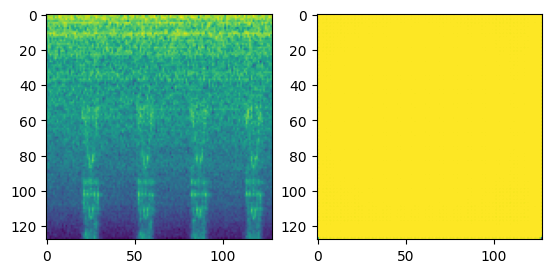

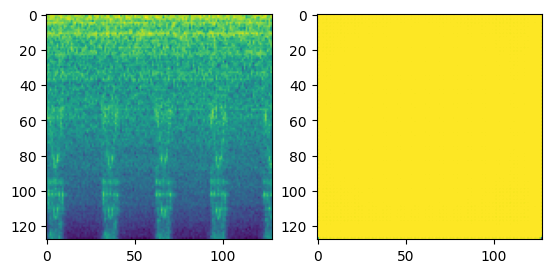

100%|██████████| 278/278 [00:37<00:00,  7.47it/s]
2024-05-25 18:36:03,454 - INFO - AUC : 0.5258988764044945
2024-05-25 18:36:03,466 - INFO - pAUC : 0.5340035481963336



============ END OF TEST FOR A MACHINE ID ============


In [20]:
import glob
import re
import itertools
from tqdm import tqdm
from sklearn import metrics

########################################################################
# control stochastic behavior
########################################################################
deterministic_everything(2022, pytorch=True)
#######################################################################


########################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def to_tensor(array):
  return torch.Tensor(array).to(device)
########################################################################
def save_csv(save_file_path,
             save_data):
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerows(save_data)


def get_machine_id_list_for_test(target_dir,
                                 dir_name="test",
                                 ext="wav"):
    """
    target_dir : str
        base directory path of "dev_data" or "eval_data"
    test_dir_name : str (default="test")
        directory containing test data
    ext : str (default="wav)
        file extension of audio files

    return :
        machine_id_list : list [ str ]
            list of machine IDs extracted from the names of test files
    """
    # create test files
    dir_path = os.path.abspath("{dir}/{dir_name}/*.{ext}".format(dir=target_dir, dir_name=dir_name, ext=ext))
    file_paths = sorted(glob.glob(dir_path))
    # extract id
    machine_id_list = sorted(list(set(itertools.chain.from_iterable(
        [re.findall('id_[0-9][0-9]', ext_id) for ext_id in file_paths]))))
    return machine_id_list


def test_file_list_generator(target_dir,
                             id_name,
                             dir_name="test",
                             prefix_normal="normal",
                             prefix_anomaly="anomaly",
                             ext="wav"):
    """
    target_dir : str
        base directory path of the dev_data or eval_data
    id_name : str
        id of wav file in <<test_dir_name>> directory
    dir_name : str (default="test")
        directory containing test data
    prefix_normal : str (default="normal")
        normal directory name
    prefix_anomaly : str (default="anomaly")
        anomaly directory name
    ext : str (default="wav")
        file extension of audio files

    return :
        if the mode is "development":
            test_files : list [ str ]
                file list for test
            test_labels : list [ boolean ]
                label info. list for test
                * normal/anomaly = 0/1
        if the mode is "evaluation":
            test_files : list [ str ]
                file list for test
    """
    com.logger.info("target_dir : {}".format(Path(target_dir+"_"+id_name).name))

    # development
    if mode:
        normal_files = sorted(
            glob.glob("{dir}/{dir_name}/{prefix_normal}_{id_name}*.{ext}".format(dir=target_dir,
                                                                                 dir_name=dir_name,
                                                                                 prefix_normal=prefix_normal,
                                                                                 id_name=id_name,
                                                                                 ext=ext)))
        normal_labels = np.zeros(len(normal_files))
        anomaly_files = sorted(
            glob.glob("{dir}/{dir_name}/{prefix_anomaly}_{id_name}*.{ext}".format(dir=target_dir,
                                                                                  dir_name=dir_name,
                                                                                  prefix_anomaly=prefix_anomaly,
                                                                                  id_name=id_name,
                                                                                  ext=ext)))
        anomaly_labels = np.ones(len(anomaly_files))
        files = np.concatenate((normal_files, anomaly_files), axis=0)
        labels = np.concatenate((normal_labels, anomaly_labels), axis=0)
        com.logger.info("test_file  num : {num}".format(num=len(files)))
        if len(files) == 0:
            com.logger.exception("no_wav_file!!")
        print("\n========================================")

    # evaluation
    else:
        files = sorted(
            glob.glob("{dir}/{dir_name}/*{id_name}*.{ext}".format(dir=target_dir,
                                                                  dir_name=dir_name,
                                                                  id_name=id_name,
                                                                  ext=ext)))
        labels = None
        com.logger.info("test_file  num : {num}".format(num=len(files)))
        if len(files) == 0:
            com.logger.exception("no_wav_file!!")
        print("\n=========================================")

    return files, labels
########################################################################


########################################################################
# main 01_test.py
########################################################################
if True:
    # check mode
    # "development": mode == True
    # "evaluation": mode == False
    mode = com.command_line_chk(args=['-d'])
    if mode is None:
        sys.exit(-1)

    # make output result directory
    os.makedirs(params.result_directory, exist_ok=True)

    # load base directory
    dirs = com.select_dirs(param=params, mode=mode)

    # initialize lines in csv for AUC and pAUC
    csv_lines = []

    # PyTorch version specific...
    to_tensor = ToTensor1ch(image=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # loop of the base directory
    for idx, target_dir in enumerate(dirs):
        print("\n===========================")
        print("[{idx}/{total}] {dirname}".format(dirname=target_dir, idx=idx+1, total=len(dirs)))
        machine_type = os.path.split(target_dir)[1]

        print("============== MODEL LOAD ==============")
        # set model path
        model_file = "{model}/model_{machine_type}.pth".format(model=params.model_directory,
                                                               machine_type=machine_type)
        print(f"model_file: {model_file}")

        # load model file
        if not os.path.exists(model_file):
            com.logger.error("{} model not found ".format(machine_type))
            sys.exit(-1)
        com.logger.info("loading model: {}".format(model_file))
        model = CNNAutoEncoder().to(device)
        load_weights(model, model_file)
        summary(device, model, input_size=(1, params.feature.n_mels, params.feature.n_mels))
        model.eval()

        if mode:
            # results by type
            csv_lines.append([machine_type])
            csv_lines.append(["id", "AUC", "pAUC"])
            performance = []

        machine_id_list = get_machine_id_list_for_test(target_dir)

        for id_str in machine_id_list:
            # load test file
            test_files, y_true = test_file_list_generator(target_dir, id_str)

            # setup anomaly score file path
            anomaly_score_csv = "{result}/anomaly_score_{machine_type}_{id_str}.csv".format(
                                                                                     result=params.result_directory,
                                                                                     machine_type=machine_type,
                                                                                     id_str=id_str)
            anomaly_score_list = []

            print("\n============== BEGIN TEST FOR A MACHINE ID ==============")
            y_pred = [0. for k in test_files]
            for file_idx, file_path in tqdm(enumerate(test_files), total=len(test_files)):
                if True:# try:
                    data = file_to_vector_array_2d(file_path,
                                                    n_mels=params.feature.n_mels,
                                                    n_fft=params.feature.n_fft,
                                                    hop_length=params.feature.hop_length,
                                                    power=params.feature.power)
                    data = normalize_0to1(data)
                    with torch.no_grad():
                        yhat = model(to_tensor(data)).cpu().detach().numpy().reshape(data.shape)
                        errors = np.mean(np.square(data - yhat), axis=1)
                        if file_idx in [0, 500]:
                            for i in range(2):
                                fig, axs = plt.subplots(1, 2)
                                axs[0].imshow(data[i])
                                axs[1].imshow(yhat[i])
                                plt.show()
                    y_pred[file_idx] = -np.mean(errors)
                    anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])


            # save anomaly score
            #save_csv(save_file_path=anomaly_score_csv, save_data=anomaly_score_list)
            #com.logger.info("anomaly score result ->  {}".format(anomaly_score_csv))

            if mode:
                # append AUC and pAUC to lists
                auc = metrics.roc_auc_score(y_true, y_pred)
                p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=params.max_fpr)
                csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
                performance.append([auc, p_auc])
                com.logger.info("AUC : {}".format(auc))
                com.logger.info("pAUC : {}".format(p_auc))

            print("\n============ END OF TEST FOR A MACHINE ID ============")

        if mode:
            # calculate averages for AUCs and pAUCs
            averaged_performance = np.mean(np.array(performance, dtype=float), axis=0)
            csv_lines.append(["Average"] + list(averaged_performance))
            csv_lines.append([])


In [21]:
csv_lines

[['slider'],
 ['id', 'AUC', 'pAUC'],
 ['00', 0.9307303370786516, 0.7871082199881727],
 ['02', 0.752434456928839, 0.57618766016164],
 ['04', 0.5258988764044945, 0.5340035481963336],
 ['Average', 0.736354556803995, 0.6324331427820488],
 []]